#  Finding Synchrony/Mimicry in Motion Energy 


## Preprocessing

In [1]:
from mpl_toolkits.mplot3d import Axes3D
from statsmodels.graphics.tsaplots import plot_acf
from pandas import DataFrame
from dtw import dtw, accelerated_dtw
from mpl_toolkits import mplot3d
from scipy import signal
import scipy as sp
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import math
import json
import csv
import os

In [70]:
# create the lists
frames = []
key_points = []
# first person
x1 = []
y1 = []
c1 = []
# second person
x2 = []
y2 = []
c2 = []

frame = 0
path = r"\json_output/"
json_files = entries = os.listdir(path)
for file in json_files:
    json_dir = path + file
    df = pd.read_json(json_dir)
    total_parts = 0    
    total_points = len(df['people'][0]['pose_keypoints_2d'])
    
    for point in range(total_points):
        if point % 3 == 0:
            
            key_points.append(int(point / 3))
            frames.append(frame)
            # parameters for the first person
            if (df['people'][0]['pose_keypoints_2d'][point] <=338 ):
                x1.append(df['people'][0]['pose_keypoints_2d'][point])
                y1.append(df['people'][0]['pose_keypoints_2d'][point + 1])
                c1.append(df['people'][0]['pose_keypoints_2d'][point + 2])
            else: 
                x2.append(df['people'][0]['pose_keypoints_2d'][point])
                y2.append(df['people'][0]['pose_keypoints_2d'][point + 1])
                c2.append(df['people'][0]['pose_keypoints_2d'][point + 2])
            # parameters for the first person
            if (df['people'][1]['pose_keypoints_2d'][point] >338):
                x2.append(df['people'][1]['pose_keypoints_2d'][point])
                y2.append(df['people'][1]['pose_keypoints_2d'][point + 1])
                c2.append(df['people'][1]['pose_keypoints_2d'][point + 2])
            else:
                x1.append(df['people'][1]['pose_keypoints_2d'][point])
                y1.append(df['people'][1]['pose_keypoints_2d'][point + 1])
                c1.append(df['people'][1]['pose_keypoints_2d'][point + 2])
           
                

    frame = frame + 1

In [71]:
print(len(x1), len(x2))
x2 = x2[:-22]
y2 = y2[:-22]
c2 = c2[:-22]
frames = frames[:-11]
key_points = key_points[:-11]
print(len(c1), len(c2))

149814 149836
149814 149814


In [23]:
data = {
    'frames': frames,
    'points' : key_points,
    'x1' : x1,
    'y1': y1,
    'c1' : c1,
    'x2' : x2,
    'y2': y2,
    'c2' : c2
}
all_data = pd.DataFrame(data)
print(all_data.head())

   frames  points       x1       y1        c1       x2       y2        c2
0       0       0  169.257  205.627  0.942253  615.746  203.973  0.911872
1       0       1  118.815  257.685  0.803236  659.976  248.152  0.828574
2       0       2  106.216  270.284  0.769094  637.920  241.847  0.809170
3       0       3  131.417  352.298  0.822463  607.903  293.981  0.773774
4       0       4  205.600  350.736  0.774575  571.563  319.173  0.713091


## Remove keypoints with low confidence

In [ ]:
for index in all_data.index:
    if all_data.loc[index,'c1']<=0.3:
        all_data.loc[index,'x1'] = 0
        all_data.loc[index,'y1'] = 0
    elif all_data.loc[index,'c2']<=0.3:
        all_data.loc[index,'x2'] = 0
        all_data.loc[index,'y2'] = 0

## Save data

In [ ]:
all_data.to_csv(r'\all_data_removed_low_confidence.csv', index=False)

##  Interpolate the missing data for each keypoint

In [ ]:
var = 'y2'
for k in range(0,25,1):
    print('Key point ', k)
    for i in range(k, int(len(all_data)/25),1):
        point= all_data[all_data['points'] == k][var].copy()
        point.interpolate(method='linear', direction = 'forward', inplace=True) 
        all_data.at[point.index[i], var] = float(point[point.index[i]])
all_data.to_csv(r'C\all_data_interpolated.csv', index=False)

# #1 Create center mass data

In [30]:
center_mass_1_x = []
center_mass_1_y = []
center_mass_2_x = []
center_mass_2_y = []
frames = []
for frame in  range(0,int(len((all_data['frames']))/25)):
    cond = all_data.loc[(all_data['frames'] == frame)]
    center_mass_1_x.append(cond['x1'].mean())
    center_mass_1_y.append(cond['y1'].mean())
    center_mass_2_x.append(cond['x2'].mean())
    center_mass_2_y.append(cond['y2'].mean())
    frames.append(frame)
                 
mass_1 = { 'center_mass_x' : center_mass_1_x,
           'center_mass_y' : center_mass_1_y,
           'frames' : frames
         }
mass_2 = { 'center_mass_x' : center_mass_2_x,
           'center_mass_y' : center_mass_2_y,
           'frames' : frames
         }
mass_3 = {
        'first_mass_x' : center_mass_1_x,
        'first_mass_y' : center_mass_1_y,
        'second_mass_x' : center_mass_2_x,
        'second_mass_y' : center_mass_2_y,
        'frames' : frames
}
first_person_mass = pd.DataFrame(mass_1)       
second_person_mass = pd.DataFrame(mass_2) 
center_mass = pd.DataFrame(mass_3)
#center_mass.to_csv(r'\center_mass.csv', index=False)
print(first_person_mass.head())
print(second_person_mass.head())

   center_mass_x  center_mass_y  frames
0      152.09608      255.73676       0
1      150.07976      257.94336       1
2      162.81084      286.44740       2
3      150.64696      257.44252       3
4      151.84952      260.20992       4
   center_mass_x  center_mass_y  frames
0      542.39544      342.91064       0
1      544.47672      342.97084       1
2      544.66716      342.15892       2
3      542.78188      347.65412       3
4      543.91080      348.15232       4


## Create movement vector by taking the euklidean distance between two frames from center mass data

In [174]:
movement_vector_first_person = []
movement_vector_second_person = []

for i in range(1, len(first_person_mass), 1):
    movement_vector_first_person.append(math.sqrt((first_person_mass['center_mass_x'][i] - first_person_mass['center_mass_x'][i-1])**2 + (first_person_mass['center_mass_y'][i] - first_person_mass['center_mass_y'][i-1])**2))
    movement_vector_second_person.append(math.sqrt((second_person_mass['center_mass_x'][i] - second_person_mass['center_mass_x'][i-1])**2 + (second_person_mass['center_mass_y'][i] - second_person_mass['center_mass_y'][i-1])**2))

vector_data = {
    'vector_first_person' : movement_vector_first_person,
    'vector_second_person' : movement_vector_second_person,
    'frames' : frames[:-1]
}
movement_vector = pd.DataFrame(vector_data)
#movement_vector.to_csv(r'\movement_vector.csv', index=False)
print(movement_vector.head())

   vector_first_person  vector_second_person  frames
0             2.989085              2.082150       0
1            31.217955              0.833955       1
2            31.452234              5.809604       2
3             3.017392              1.233963       3
4            76.222581              0.365437       4


In [31]:
mass_vector_first_person_x = []
mass_vector_first_person_y = []
mass_vector_second_person_x = []
mass_vector_second_person_y = []
for i in range(1, len(center_mass), 1):
    mass_vector_first_person_x.append(center_mass['first_mass_x'][i] - center_mass['first_mass_x'][i-1])
    mass_vector_first_person_y.append(center_mass['first_mass_y'][i] - center_mass['first_mass_y'][i-1])
    mass_vector_second_person_x.append(center_mass['second_mass_x'][i] - center_mass['second_mass_x'][i-1])
    mass_vector_second_person_y.append(center_mass['second_mass_y'][i] - center_mass['second_mass_y'][i-1])

mass_vector_data = {
    'mass_vector_first_person_x' : mass_vector_first_person_x,
    'mass_vector_first_person_y' : mass_vector_first_person_y,
    'mass_vector_second_person_x' : mass_vector_second_person_x,
    'mass_vector_second_person_y' : mass_vector_second_person_y,
    'frames' : frames[:-1]
}
movement_mass_vector = pd.DataFrame(mass_vector_data)
movement_mass_vector.to_csv(r'\movement_mass_vector.csv', index=False)
print(movement_mass_vector.head())

   mass_vector_first_person_x  mass_vector_first_person_y  \
0                    -2.01632                     2.20660   
1                    12.73108                    28.50404   
2                   -12.16388                   -29.00488   
3                     1.20256                     2.76740   
4                   -38.95408                   -65.51688   

   mass_vector_second_person_x  mass_vector_second_person_y  frames  
0                      2.08128                      0.06020       0  
1                      0.19044                     -0.81192       1  
2                     -1.88528                      5.49520       2  
3                      1.12892                      0.49820       3  
4                      0.19000                      0.31216       4  


# #2 Create motion energy

## Create time series for each person for each key point

In [ ]:
time_series_first_person = [[] for x in range(int(25))]
time_series_second_person = [[] for x in range(int(25))]
for k in range(0,25,1):
    print('Key point ', k)
    point_x1 = all_data[all_data['points'] == k]['x1']
    point_x2 = all_data[all_data['points'] == k]['x2']
    point_y1 = all_data[all_data['points'] == k]['y1']
    point_y2 = all_data[all_data['points'] == k]['y2']
    for i in range(1, int(len(all_data)/25),1): 
        time_series_first_person[k].append(math.sqrt((point_x1.values[i] - point_x1.values[i-1])**2 + (point_y1.values[i] - point_y1.values[i-1])**2))
        time_series_second_person[k].append(math.sqrt((point_x2.values[i] - point_x2.values[i-1])**2 + (point_y2.values[i] - point_y2.values[i-1])**2))

## Create motion energy time series for each person by adding for every frame the all the keypoints

In [ ]:
motion_energy_first_person = []
motion_energy_second_person = []

for i in range(0, len(time_series_second_person[k]),1):
    energy1 = 0
    energy2 = 0
    for k in range(0,25,1):   
        energy1 += time_series_first_person[k][i]
        energy2 += time_series_second_person[k][i]
    motion_energy_first_person.append(energy1)
    motion_energy_second_person.append(energy2)

In [ ]:
frames = [x for x in range(0, len(motion_energy_first_person))]
motion_energy_data = {
    'motion_energy_first_person' : motion_energy_first_person,
    'motion_energy_second_person' : motion_energy_second_person,
    'frames' : frames[:]
}
motion_energy = pd.DataFrame(motion_energy_data)
motion_energy.to_csv(r'\motion_energy.csv', index=False)

## Use Moving Median filter to smooth the data

In [ ]:
motion_energy = pd.read_csv(r'\motion_energy_original_data.csv')
window_length = 25
motion_energy['motion_energy_first_person'] = sp.signal.medfilt(motion_energy['motion_energy_first_person'], window_length)
motion_energy['motion_energy_second_person'] = sp.signal.medfilt(motion_energy['motion_energy_second_person'], window_length)
motion_energy.to_csv(r'\motion_energy_original_data_median.csv', index=False)

## Use ARIMA Model and take the residuals to remove autocorrelation

                                   ARIMA Model Results                                   
Dep. Variable:     D.motion_energy_second_person   No. Observations:                 5966
Model:                            ARIMA(5, 1, 0)   Log Likelihood              -44656.040
Method:                                  css-mle   S.D. of innovations            431.010
Date:                           Wed, 13 Jan 2021   AIC                          89326.079
Time:                                   17:43:33   BIC                          89372.936
Sample:                                        1   HQIC                         89342.356
                                                                                         
                                          coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------------------------------
const                                  -0.3601      2.907     -0.124    

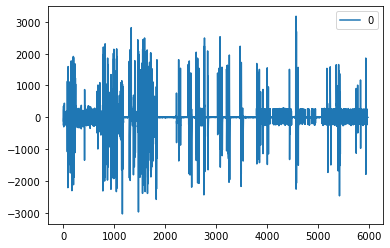

In [210]:
import warnings
warnings.filterwarnings("ignore")

from statsmodels.tsa.arima_model import ARIMA
series = pd.read_csv(r'\motion_energy_removed_frames.csv')
#X = pd.read_csv(r'\preprocessed_data_norm_P1.csv')
#Y = pd.read_csv(r'\preprocessed_data_norm_P2.csv')
X = series['motion_energy_first_person']
Y = series['motion_energy_second_person']

model = ARIMA(Y, order=(5,1,0))
model_fit = model.fit(disp=0)
# summary of fit model
print(model_fit.summary())
# line plot of residuals
residuals = DataFrame(model_fit.resid)
residuals.plot()
plt.show()
residuals.to_csv(r'\residuals_preprocessed_data_2.csv', index=False)

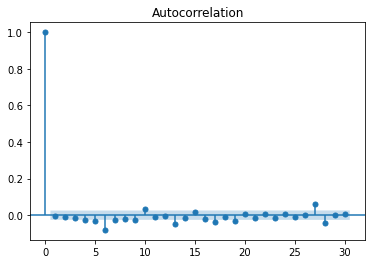

0   -0.027302
dtype: float64
0    431.010877
dtype: float64


In [211]:
plot_acf(residuals, lags=30)
plt.show()
print(np.mean(residuals))
print(np.std(residuals))

## Normalise the time series

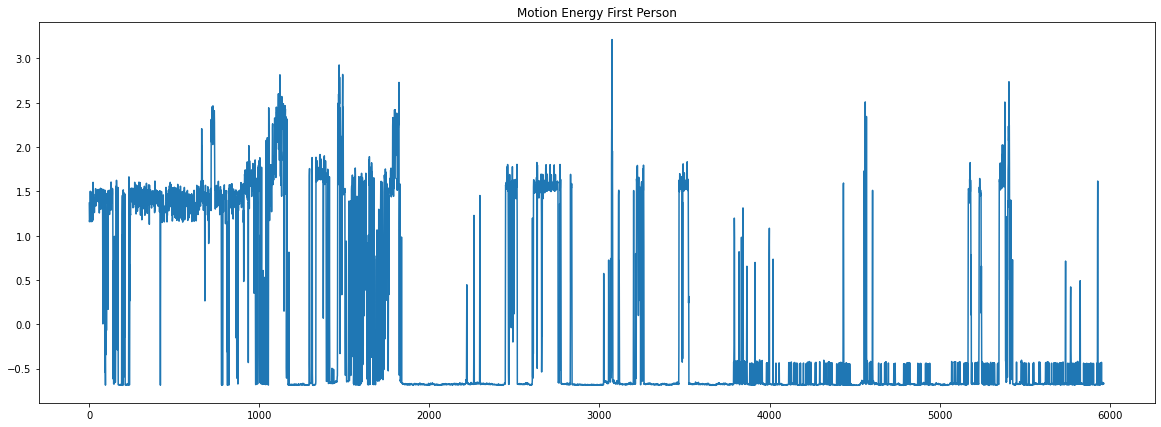

In [19]:
df = pd.read_csv(r'\motion_energy_removed_frames.csv')
avrg1, dev1 = df['motion_energy_first_person'].mean(), df['motion_energy_first_person'].std()
avrg2, dev2 = df['motion_energy_second_person'].mean(), df['motion_energy_second_person'].std()

rp1 = df['motion_energy_first_person'].copy()
rp1 = (rp1- avrg1)/dev1
rp2 = df['motion_energy_second_person'].copy()
rp2 = (rp2- avrg2)/dev2
plt.figure(figsize=(20,7))
plt.plot(rp2)
plt.title('Motion Energy First Person')
plt.show()


rp1.to_csv(r'\preprocessed_data_norm_P1.csv', index=False)
rp2.to_csv(r'\preprocessed_data_norm_P2.csv', index=False)

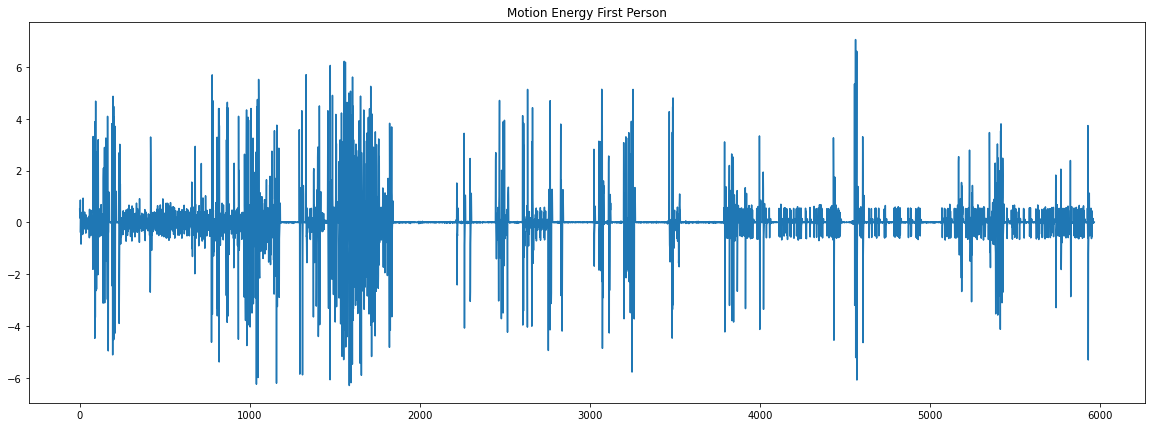

In [50]:
df1 = pd.read_csv(r'\residuals_preprocessed_data_P1.csv')
df2 = pd.read_csv(r'\residuals_preprocessed_data_P2.csv')

avrg1, dev1 = df1['0'].mean(), df1['0'].std()
avrg2, dev2 = df2['0'].mean(), df2['0'].std()

rp1 = df1['0'].copy()
rp1 = (rp1- avrg1)/dev1
rp2 = df2['0'].copy()
rp2 = (rp2- avrg2)/dev2
plt.figure(figsize=(20,7))
plt.plot(rp2)
plt.title('Motion Energy First Person')
plt.show()


rp1.to_csv(r'\norm_residuals_preprocessed_data_P1.csv', index=False)
rp2.to_csv(r'\norm_residuals_preprocessed_data_P2.csv', index=False)